In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [3]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()


### Kaggle LSUN (64x64)

In [11]:
lsun_path = kagglehub.dataset_download("ajaykgp12/lsunchurch")

In [13]:
import numpy as np
X_train = np.load(os.path.join(lsun_path, "church_outdoor_train_lmdb_color_64.npy"))

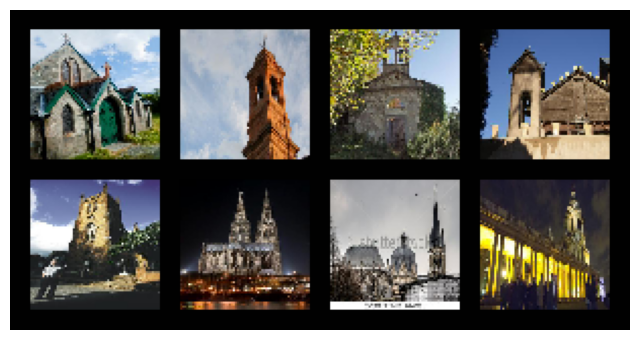

In [43]:
i = np.random.randint(10000)
sample_imgs = torch.tensor(np.permute_dims(X_train[i:i+8], (0, 3, 1, 2)))
show_images(sample_imgs)

### Full-Res LSUN (smaller dimension 256)

torch.Size([4, 3, 256, 256])


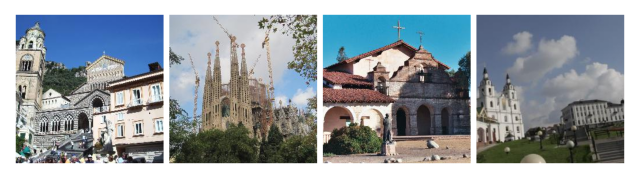

In [10]:
from torchvision.datasets import LSUN

# before running this, you need to download the lsun church outdoor images manually
# this takes around 10 minutes because the server is so slow
# mkdir lsun-church-outdoor
# git clone https://github.com/fyu/lsun
# cd lsun
# python3 download.py -c church_outdoor -o "../lsun-church-outdoor"
# then manually extract church_outdoor_train_lmdb.zip to church_outdoor_train_lmdb/, in the same directory
# you will also need to pip install lmdb

class LSUNChurch(Dataset):
    def __init__(self, img_size=256):
        self.img_size = img_size
        self.lsun_raw = LSUN("./lsun-church-outdoor", classes=["church_outdoor_train"], transform=to_tensor)

    def __getitem__(self, index):
        img = self.lsun_raw[index][0]  # [0] to get image only
        return T.CenterCrop(self.img_size)(img)
    
    def __len__(self):
        return len(self.lsun_raw)

imgs = next(iter(DataLoader(LSUNChurch(), batch_size=4, shuffle=True)))
print(imgs.shape)
show_images(imgs)

In [23]:
from torchvision.utils import save_image

# save subset of lsun - 2000 images should be plenty, considering we have 1200 monet
os.makedirs("lsun-subset", exist_ok=True)
for i, batch in enumerate(DataLoader(LSUNChurch(), batch_size=1, shuffle=True)):
    if i > 10:
        break
    img = batch[0]  # remove from batched structure
    # make sure at least 256 in size
    if min(img.shape[1], img.shape[2]) < 256:
        continue
    save_path = os.path.join("lsun-subset", f"{i}.png")
    save_image(img, save_path)

### Monet and Van Gogh

In [11]:
class Monet(Dataset):
    def __init__(self, img_size=256):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)
        self.img_names = list(filter(lambda s: os.path.isfile(os.path.join(self.data_path, s)), self.img_names))

        # resize images to lower resolution
        print("Image size:", img_size)
        if img_size == 256:
            self.resized_data_path = self.data_path
        else:
            self.resized_data_path = os.path.join(self.data_path, f"resized_{img_size}")
        
        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.resized_data_path, img_name)
            if os.path.exists(resized_path):
                continue

            # resize to specified img size
            orig_img_path = os.path.join(self.data_path, img_name)
            with Image.open(orig_img_path) as img:
                resized_img = img.resize((img_size, img_size))
                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.resized_data_path, self.img_names[index]))


class VanGogh(Dataset):
    def __init__(self, img_size=256):
        self.data_path = kagglehub.dataset_download(
            "ipythonx/van-gogh-paintings")
        self.df = pd.read_csv(os.path.join(
            self.data_path, "VanGoghPaintings.csv"))

        # only use folders containing painting images
        exclude = ["Drawings", "Sketches in letters",
                   "Works of the young van Gogh"]
        mask = ~self.df["class_name"].isin(exclude)
        self.img_names = self.df[mask]["image_path"].reset_index(drop=True)

        # remove unused path prefix, replace with correct prefix
        self.img_names = self.img_names.apply(
            lambda x: x.replace("/kaggle/input/van-gogh-paintings/", "VincentVanGogh/"))
        
        self.resized_data_path = os.path.join(self.data_path, f"resized_{img_size}")

        # resize images to lower resolution and square
        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.resized_data_path, img_name)
            if os.path.exists(resized_path):
                continue

            # crop to a square and resize to small resolution
            orig_img_path = os.path.join(self.data_path, img_name)
            # check if 256 size exists for faster resizing
            orig_img_path_256 = os.path.join(self.data_path, "resized_256", img_name)
            if os.path.exists(orig_img_path_256):
                orig_img_path = os.path.join(self.data_path, "resized_256", img_name)

            with Image.open(orig_img_path) as img:
                # get the shorter side of the image and calculate cropping offsets
                short_side = min(img.width, img.height)
                left = (img.width - short_side) // 2
                top = (img.height - short_side) // 2
                right = left + short_side
                bottom = top + short_side

                # crop the image to a square, and resize
                cropped_img = img.crop((left, top, right, bottom))
                resized_img = cropped_img.resize((img_size, img_size))

                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.resized_data_path, self.img_names[index]))

In [12]:
monet_full_size = Monet()
monet_32 = Monet(img_size=32)
monet_64 = Monet(img_size=64)

Image size: 256
Saving resized images...


100%|██████████| 1193/1193 [00:00<00:00, 15064.12it/s]


Image size: 32
Saving resized images...


100%|██████████| 1193/1193 [00:00<00:00, 7078.09it/s]


Image size: 64
Saving resized images...


100%|██████████| 1193/1193 [00:03<00:00, 332.89it/s]


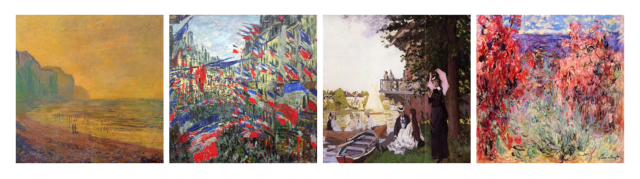

In [9]:
monet_loader = DataLoader(monet_full_size, batch_size=4, shuffle=True)
show_images(next(iter(monet_loader)))

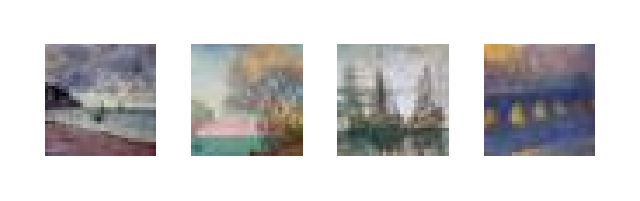

In [10]:
monet_loader = DataLoader(monet_32, batch_size=4, shuffle=True)
show_images(next(iter(monet_loader)))

In [ ]:
vangogh_full_size = VanGogh()
vangogh_32 = VanGogh(img_size=32)

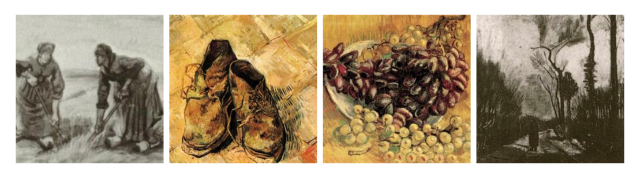

In [ ]:
van_gogh_loader = DataLoader(vangogh_full_size, batch_size=4, shuffle=True)
show_images(next(iter(van_gogh_loader)))

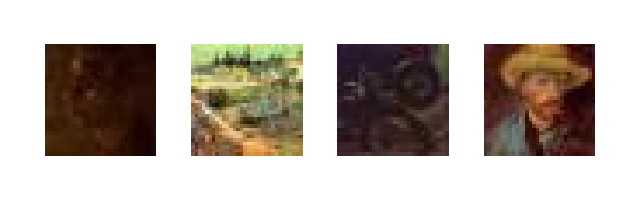

In [ ]:
van_gogh_loader = DataLoader(vangogh_32, batch_size=4, shuffle=True)
show_images(next(iter(van_gogh_loader)))